# Notebook for analysing the univariate stats of all tables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-dark')
 
from sqlalchemy import create_engine,text
user = 'root'
passwords = '7003890541'
host = 'localhost'
port = 3306
database = 'synthea'

engine = create_engine(f"mysql+pymysql://{user}:{passwords}@{host}:{port}/{database}")
def sql(query , engine = engine):
    return pd.read_sql(query,engine)


def select(table_name):
    return sql(f'select * from {table_name} limit 5')


def run(query):
    with engine.connect() as con:
        con.execute(text(query))
        con.commit()

In [2]:
imp_tables = [
    'encounters',
    'patients',
    'careplans',
    'conditions',
    'medications',
    'observations',
    'organizations',
    'procedures',
    'providers'
]

In [3]:
dict = {}
for tables in imp_tables:
    query = f'''
        select count(*) as row_count from {tables};
    '''
    df = sql(query)
    dict[tables] = df['row_count'][0]

pd.DataFrame.from_dict(dict,orient='index',columns=['row_count']).reset_index().rename(columns={'index':'table_name'})

,table_name,row_count
0,encounters,53346
1,patients,1171
2,careplans,3483
3,conditions,8376
4,medications,42989
5,observations,299697
6,organizations,1119
7,procedures,34981
8,providers,5855


`SO IT DOES NOT MEAN THAT EVERY ENCOUNTER CAN HAVE PROCEDURES, MEDICATIONS, CAREPLANS, OR DETECTED CONDITION`

**Fetch ALL Columns**

In [11]:
def fetch_all_cols(table):
    query = f'''
        select column_name from information_schema.columns
        where table_name = '{table}' and
        table_schema = database()
    '''
    df = sql(query)
    return df['COLUMN_NAME'].values.tolist()

**Find NULL Values**

In [ ]:
def find_nulls(table):
    dict ={}
    for col in fetch_all_cols(table):
        query = f'''
            select sum({col} is null) as {col}_nulls from {table}
        '''
        df =sql(query)
        dict[col] = df.iloc[0].values.astype('int')
    display(pd.DataFrame.
            from_dict(dict,orient='index',columns=['null_values']).
            reset_index().
            rename(columns={'index':'column_names'}))

**Plots a PIE CHART**

In [52]:
def pie_plot(columns,table_name):
    for col in columns:
        query = f'''
            select 
            {col},
            round(100*(count(*)/(select count(*) from {table_name})),2) as percentage
            from {table_name}
            group by {col}
            order by percentage desc
            limit 10;
        '''
        df = sql(query)
        plt.figure(figsize=(5,5))
        plt.pie(df['percentage'],labels=df[col].tolist(),autopct="%.2f%%",colors=plt.cm.Set3.colors,wedgeprops={'edgecolor':'black'})
        plt.title(f"Distribution of {col}",weight ='bold')
        plt.show()

**PLots a KDEPLOT**

In [68]:
def kde_plot(columns,table_name):
    for col in columns:
        query = f'''
            select {col} as {col} from {table_name};
        '''
        df = sql(query)
        mini = df[col].min()
        maxi = df[col].max()
        plt.figure(figsize=(24,5))
        sns.kdeplot(x=col,data=df,color= 'teal',fill=True)
        plt.axvline(mini,linestyle ='--',color = 'orange',label='minimum')
        plt.axvline(df[col].quantile(.25),linestyle ='--',color = 'black',label='25th')
        plt.axvline(df[col].mean(),linestyle ='--',color = 'blue',label = 'mean')
        plt.axvline(df[col].median(),linestyle ='--',color = 'red',label = 'median')
        plt.axvline(df[col].quantile(.75),linestyle ='--',color = 'green',label =' 75th')
        plt.axvline(maxi,linestyle ='--',color = 'orange',label='maxi')
        plt.legend(fontsize = 12)
        plt.grid(alpha = 1)
        plt.xticks(np.linspace(mini,maxi,20))
        plt.title(f"Distribution of {col}",weight = 'bold')
        plt.tight_layout()
        plt.show()

## Encounters

In [69]:
select('encounters').head(1)

,id,start,stop,patient,organization,provider,payer,class,description,basic_cost,total_cost,payer_coverage,reason
0,d0c40d10-8d87-447e-836e-99d26ad52ea5,2010-01-23 17:45:28,2010-01-23 18:10:28,034e9e3b-2def-4559-bb2a-7850888ae060,e002090d-4e92-300e-b41e-7d1f21dee4c6,e6283e46-fd81-3611-9459-0edb1c3da357,6e2f1a2d-27bd-3701-8d08-dae202c58632,ambulatory,encounter for symptom,129.16,129.16,54.16,acute bronchitis (disorder)


In [70]:
find_nulls('encounters')

,column_names,null_values
0,basic_cost,0
1,class,0
2,description,0
3,id,0
4,organization,0
5,patient,0
6,payer,0
7,payer_coverage,0
8,provider,0
9,reason,0


`NO NULL VALUES IN ENCOUNTERS TABLE`

In [76]:
sql(
    '''
    select count(*) as total_rows,
    count(distinct id) as total_unique_id ,
    count(distinct patient) as total_unique_patient,
    count(distinct organization) as total_unique_organization,
    count(distinct provider) as total_unique_provider,
    count(distinct payer) as total_unique_payer
    from encounters
'''
)

,total_rows,total_unique_id,total_unique_patient,total_unique_organization,total_unique_provider,total_unique_payer
0,53346,53346,1171,1103,1104,10


`THERE IS NO DUPLICATE ID`

`PATIENT RECORD OF 1171 USERS ARE PRESENT`

`1103 RECORDS OF ORGANIZATION IS PRESENT`

`1104 TOTAL PROVIDER RECORD IS PRESENT`

In [78]:
sql(
    '''
    select timestampdiff(YEAR,min(start),max(start)) as range_of_data_in_years from encounters
'''
)

,range_of_data_in_years
0,107


`DATA OF 107 LONG YEARS ARE PRESENT THERE`

In [71]:
fetch_all_cols('encounters')

['basic_cost',
 'class',
 'description',
 'id',
 'organization',
 'patient',
 'payer',
 'payer_coverage',
 'provider',
 'reason',
 'start',
 'stop',
 'total_cost']

In [72]:
cat_cols = ['class','description','reason',]
num_cols = ['basic_cost','total_cost','payer_coverage']

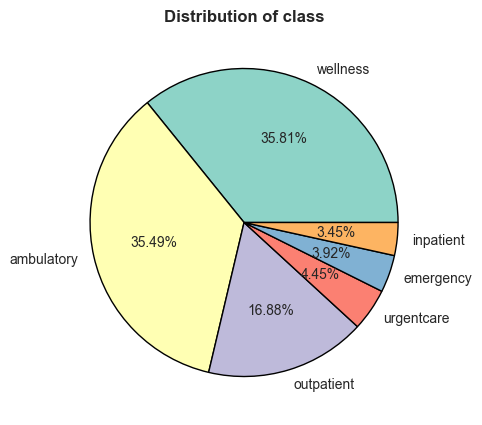

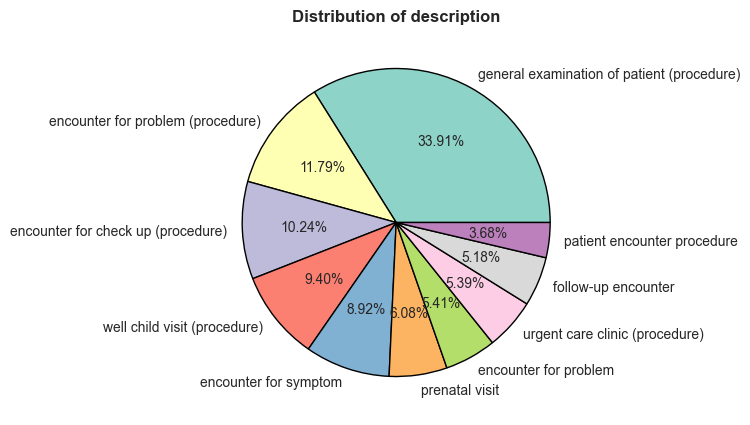

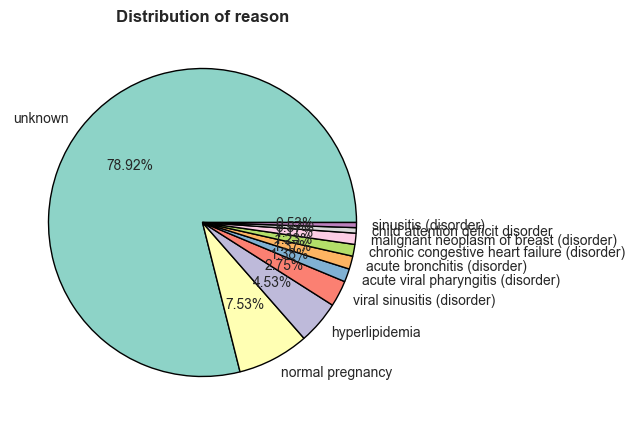

In [73]:
pie_plot(cat_cols,'encounters')

`APPROX 70% OF PEOPLE COME FOR ROUTINE CHECKUP OR NORMAL ILLNESS`

`MOST PATIENTS COME FOR GENERAL EXAMINATION`

`MOST OF THE REASON IS UNKNOWN IN THE DATA`

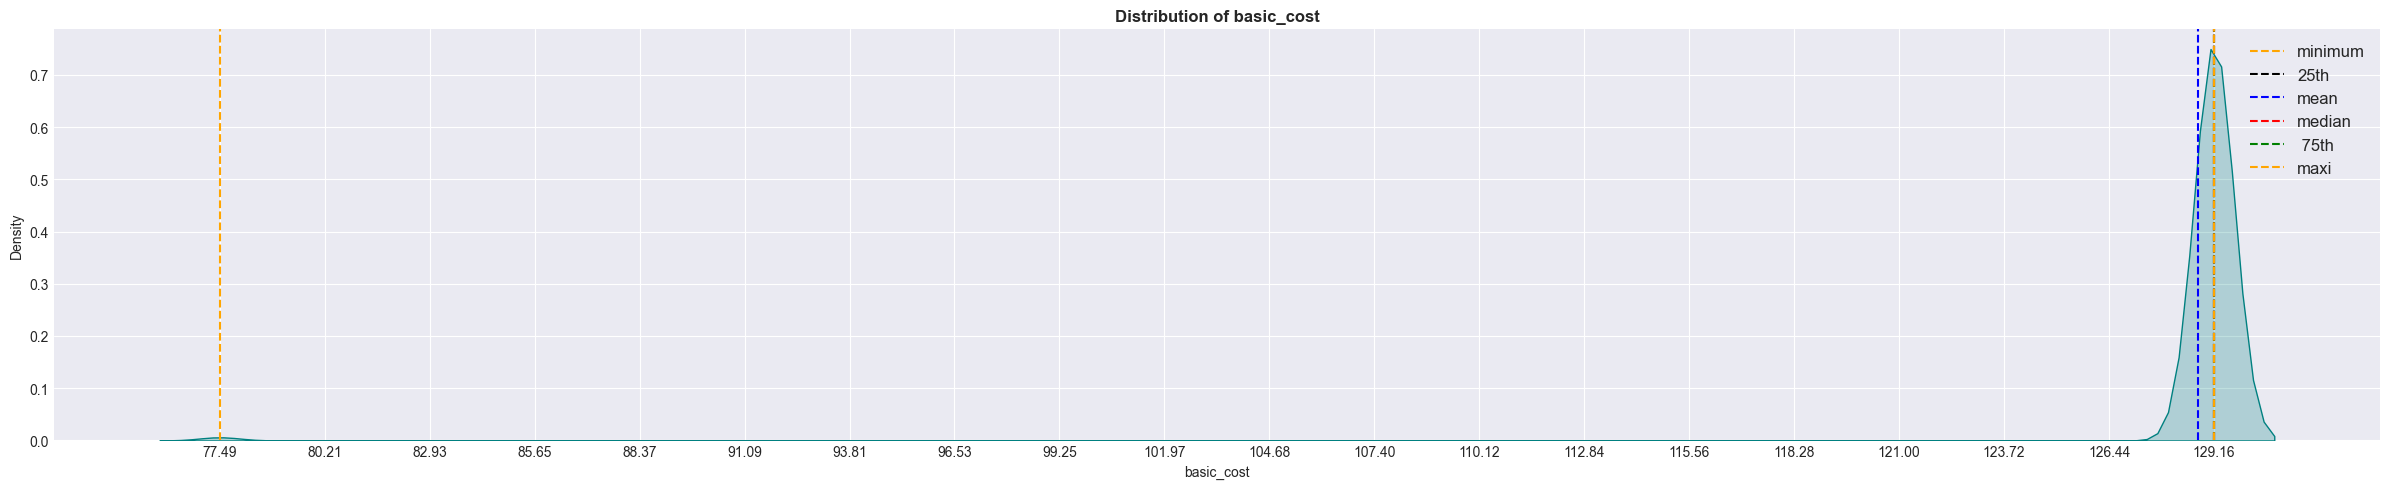

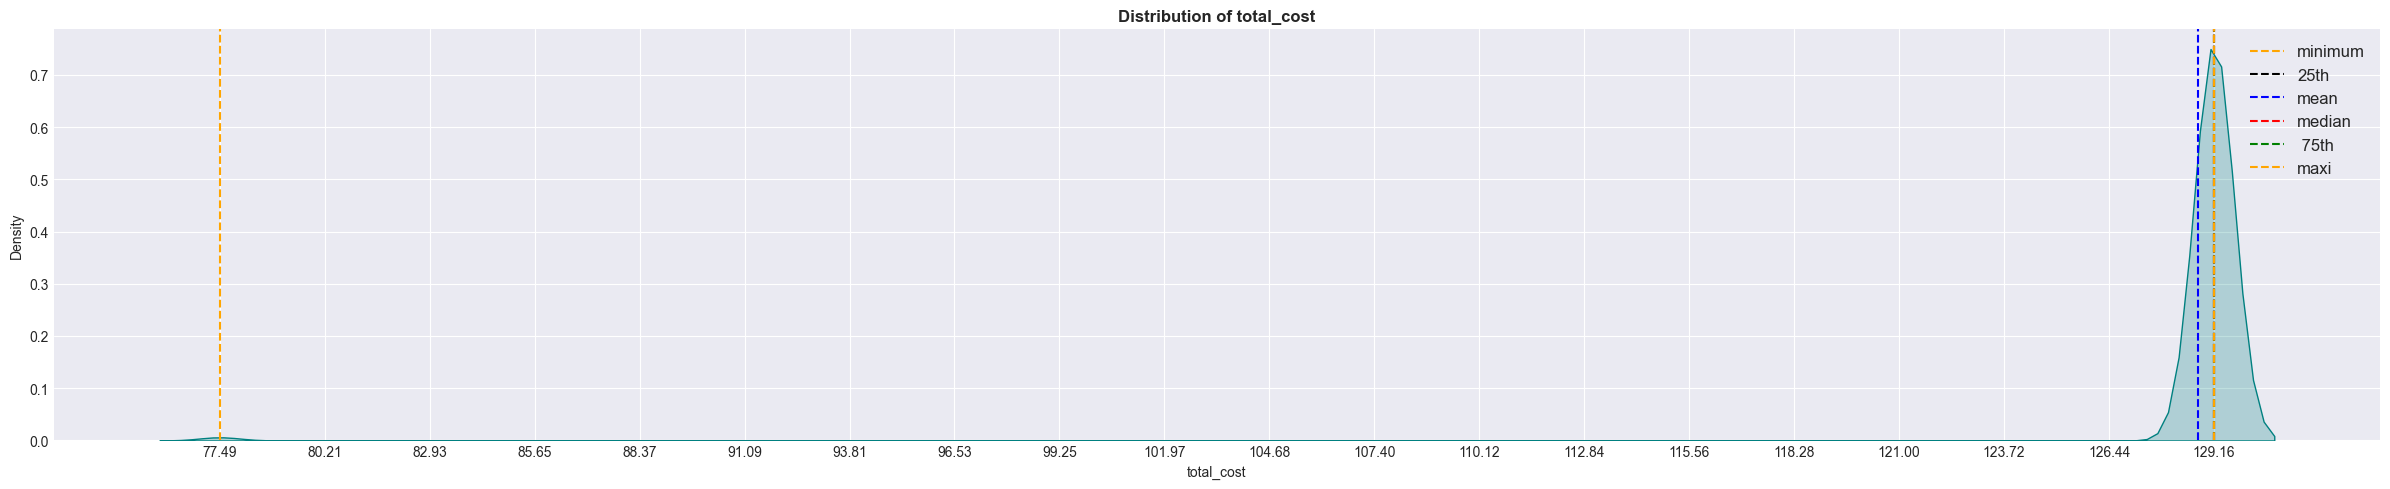

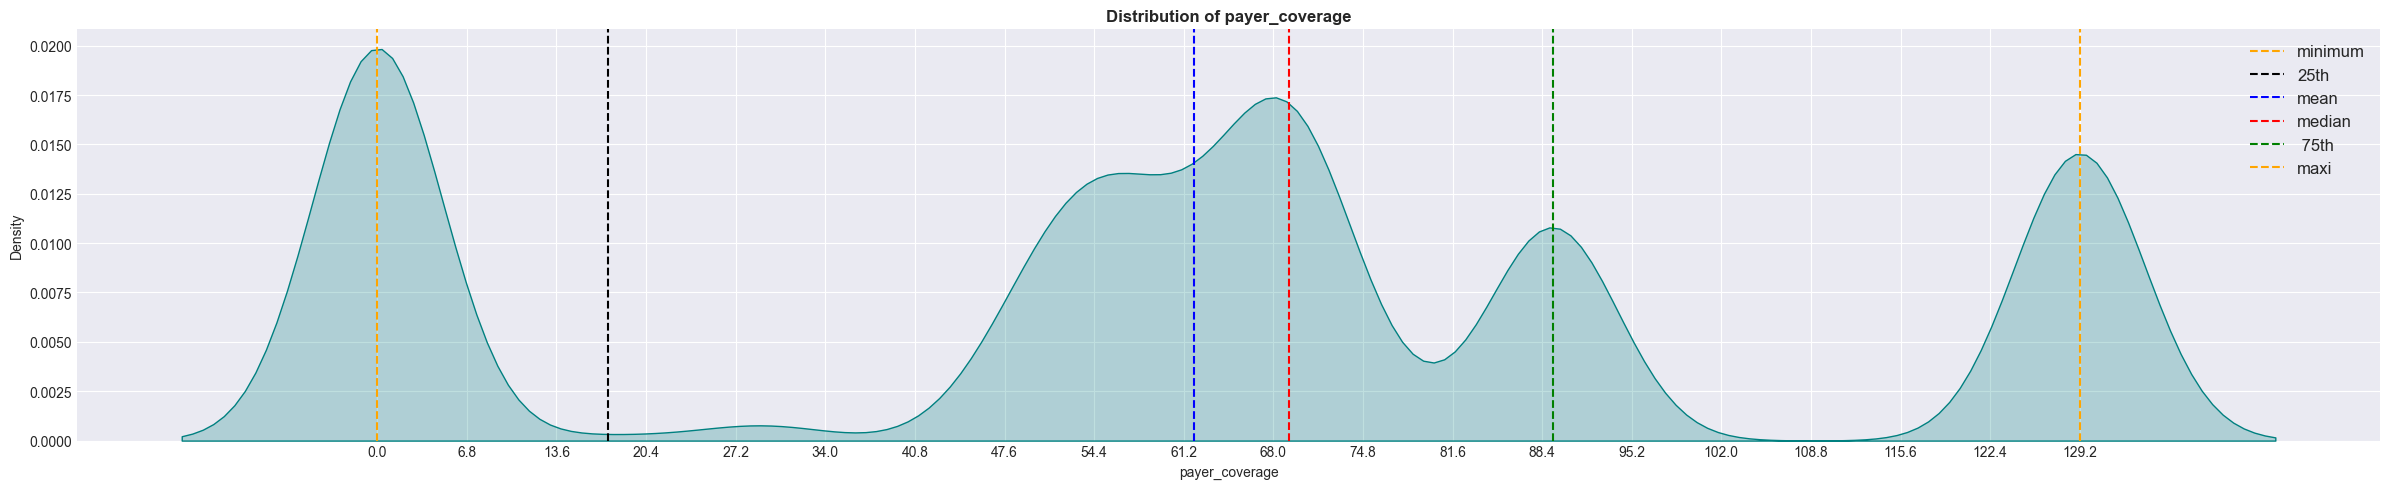

In [74]:
kde_plot(num_cols,'encounters')

## Careplans

In [79]:
select('careplans').head(1)

,id,start,stop,patient,encounter,description,reason
0,d2500b8c-e830-433a-8b9d-368d30741520,2010-01-23,2012-01-23,034e9e3b-2def-4559-bb2a-7850888ae060,d0c40d10-8d87-447e-836e-99d26ad52ea5,respiratory therapy,acute bronchitis (disorder)


In [80]:
find_nulls('careplans')

,column_names,null_values
0,description,0
1,encounter,0
2,id,0
3,patient,0
4,reason,0
5,start,0
6,stop,1532


`THERE ARE 1532 NULL VALUES, IT IS POSSIBLE THAT THEY ARE STILL IN ANY CAREPLAN`

In [92]:
careplan_duration = sql(
    '''
    select datediff(stop,start) as difference
    from careplans
    where stop is not null;
'''
)

In [103]:
careplan_duration.describe().round(2)

,difference
count,1951.00
mean,193.42
std,584.35
min,1.00
25%,21.00
50%,60.00
75%,217.00
max,10203.00


`HALF OF THE CAREPLANS HAVE DURATION OF 2 MONTHS ONLY, VERY FEW HAVE LONG DURATION OR CAREPLANS`

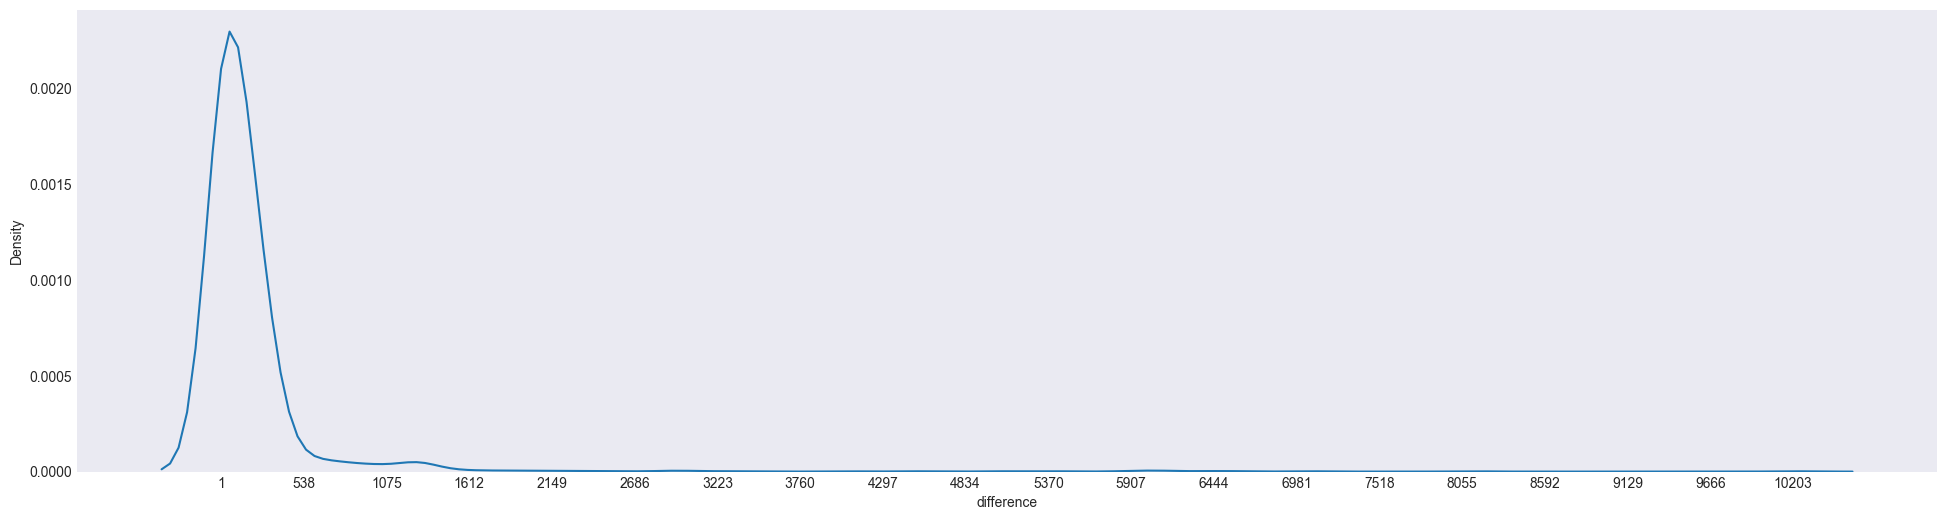

In [101]:
plt.figure(figsize=(24,6))
sns.kdeplot(careplan_duration['difference'])
plt.xticks(np.linspace(careplan_duration['difference'].min(),careplan_duration['difference'].max(),20))
plt.show()

In [81]:
fetch_all_cols('careplans')

['description', 'encounter', 'id', 'patient', 'reason', 'start', 'stop']

In [82]:
cat_cols = ['description', 'reason']

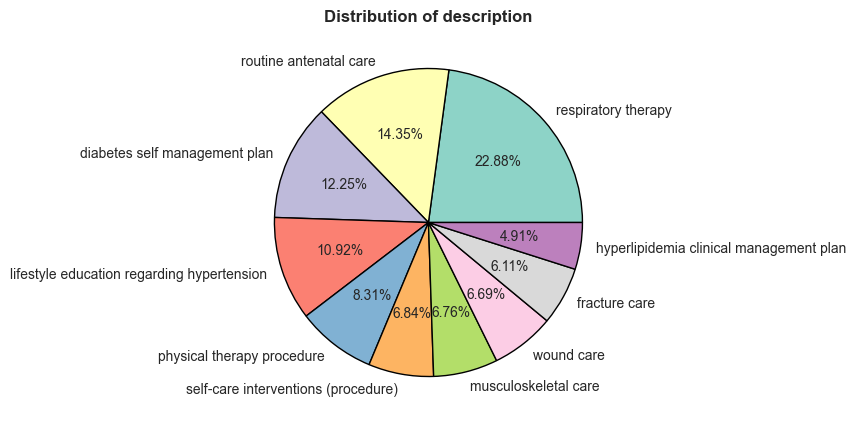

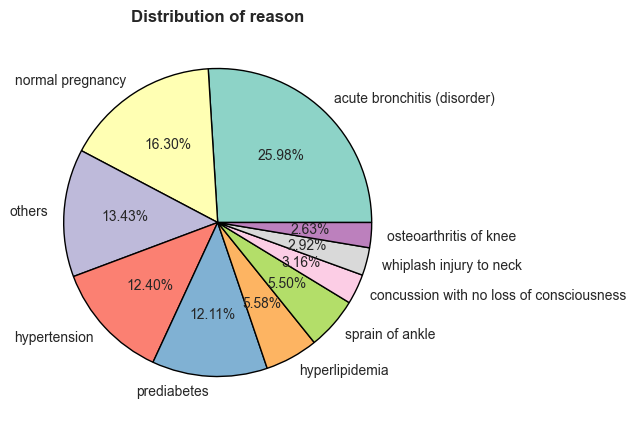

In [83]:
pie_plot(cat_cols,'careplans')

`MOST OF THE CAREPLANS ARE RESPIRATORY THERAPY`

`MOST NUMBER OF REASON FOR CAREPLAN IS ACUTE BRONCHITIS DISORDER`

## Conditions

## Medications

## Observations

## Organizations

## Procedures

## Providers